### Importing Libraries and Functions

In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import xgboost as xgb
import lightgbm as lgb
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

import seaborn as sns 

import warnings

### Additional Settings

Suppressing warnings to improve readability and showing all columns of the datasets to make for easier data exploration and analysis.

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
warnings.filterwarnings("ignore")

### Reading the Data

In [4]:
df_train=pd.read_csv('data/raw/train.csv')
df_test=pd.read_csv('data/raw/test.csv')

### Data Exploration

First we take a quick look at the training dataset.

In [5]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


A few manipulations to make the data easier for modeling and exploration.

In [7]:
# Converting booleans to binary
df_train['CryoSleep']=df_train['CryoSleep'].astype(bool).astype(int)
df_train['VIP']=df_train['VIP'].astype(bool).astype(int)
df_train['Transported']=df_train['Transported'].astype(int)

In [8]:
# Dividing the Cabin column into three different variables - Deck, Num and Side (as explained in the README)
df_train['Cabin_deck']=df_train['Cabin'].str.split('/', expand=True)[0]
df_train['Cabin_num']=df_train['Cabin'].str.split('/', expand=True)[1]
df_train['Cabin_side']=df_train['Cabin'].str.split('/', expand=True)[2]

In [9]:
# Calculating the number of people in the same group as the passenger
df_train['GroupId']=df_train['PassengerId'].str.split('_', expand=True)[0]
passenger_ids=df_train['PassengerId'].str.split('_', expand=True)
passenger_ids=passenger_ids.groupby(0)[1].max().astype(int).reset_index().rename(columns={0:'GroupId', 1:'people_in_group'})

df_train=pd.merge(df_train, passenger_ids, how = 'left', on = ['GroupId'])

In [10]:
# Sanity check - everything's good!
print('Total Ids in Training Dataset:', len(df_train))
print('Total Ids in Passenger IDs Dataset:', passenger_ids['people_in_group'].sum())

Total Ids in Training Dataset: 8693
Total Ids in Passenger IDs Dataset: 8693


In [11]:
# Calculating the number of people sharing the same last name
df_train['Last_name']=df_train['Name'].str.split(' ', expand=True)[1]
families=df_train['Name'].str.split(' ', expand=True)
families=families.groupby(1)[0].count().reset_index().rename(columns={0:'family_members', 1:'Last_name'})

df_train=pd.merge(df_train, families, how = 'left', on = ['Last_name'])

In [12]:
# Calculating the number of people sharing the same cabin
cabin_vol=df_train.groupby(['Cabin_num'])['PassengerId'].count().reset_index().rename(columns={'PassengerId':'people_in_cabin'})
df_train=pd.merge(df_train, cabin_vol, how = 'left', on = ['Cabin_num'])

In [13]:
# Adding up the total value spent by the guest in all categories and adding a flag if any value was spent
df_train['total_value_spent']=df_train[['RoomService',	'FoodCourt',	'ShoppingMall',	'Spa']].sum(axis=1)
df_train['spent_any']=np.where(df_train['total_value_spent']>0,1,0)

In [14]:
# Flagging loners in the spaceship and people with private cabins
df_train['Alone']=np.where((df_train['people_in_group']==1) & (df_train['family_members']==1),1,0)
df_train['Private_cabin']=np.where(df_train['people_in_cabin']==1,1,0)

Next we evaluate how these variables are related to our target.

In [15]:
df_train.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin
count,8693.000000,8514.000000,8693.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000,8693.000000,8493.000000,8494.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,0.374324,28.827930,0.046244,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624,2.035546,5.428117,8.037203,1142.604509,0.574255,0.039687,0.030829
std,0.483976,14.489021,0.210025,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016,1.596347,2.891901,5.214669,2327.986241,0.494484,0.195234,0.172865
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,5.000000,7.000000,420.000000,1.000000,0.000000,0.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000,3.000000,7.000000,12.000000,1193.000000,1.000000,0.000000,0.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,8.000000,18.000000,28.000000,35970.000000,1.000000,1.000000,1.000000


In [16]:
target = 'Transported'

In [17]:
df_train.groupby('HomePlanet')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
HomePlanet,,
Earth,4602,0.423946
Mars,1759,0.523024
Europa,2131,0.658846


In [18]:
df_train.groupby('Destination')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
Destination,,
TRAPPIST-1e,5915,0.471175
PSO J318.5-22,796,0.503769
55 Cancri e,1800,0.610000


In [18]:
df_train.groupby('VIP')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
VIP,,
1,402,0.447761
0,8291,0.506332


In [19]:
df_train.groupby('CryoSleep')[target].agg(['count', 'mean']).sort_values('mean')

,count,mean
CryoSleep,,
0,5439,0.328921
1,3254,0.795636


In [24]:
df_train.groupby(pd.qcut(df_train['Age'], 10))[target].agg(['count', 'mean'])

,count,mean
Age,,
"(-0.001, 13.0]",947,0.671595
"(13.0, 18.0]",918,0.541394
"(18.0, 21.0]",881,0.442679
"(21.0, 24.0]",907,0.452040
"(24.0, 27.0]",770,0.483117
"(27.0, 31.0]",882,0.484127
"(31.0, 35.0]",696,0.481322
"(35.0, 41.0]",911,0.478595
"(41.0, 49.0]",791,0.494311


In [21]:
df_train.groupby(pd.qcut(df_train['RoomService'], 15, duplicates='drop'))[target].agg(['count', 'mean'])

,count,mean
RoomService,,
"(-0.001, 1.0]",5694,0.627327
"(1.0, 29.0]",551,0.353902
"(29.0, 175.6]",564,0.370567
"(175.6, 553.0]",570,0.263158
"(553.0, 1044.8]",565,0.180531
"(1044.8, 14327.0]",568,0.117958


In [22]:
df_train.groupby(pd.qcut(df_train['ShoppingMall'], 15, duplicates='drop'))[target].agg(['count', 'mean'])

,count,mean
ShoppingMall,,
"(-0.001, 1.0]",5740,0.589199
"(1.0, 16.0]",490,0.240816
"(16.0, 97.0]",559,0.205725
"(97.0, 397.0]",565,0.223009
"(397.0, 804.4]",565,0.387611
"(804.4, 23492.0]",566,0.537102


In [21]:
df_train.groupby(pd.qcut(df_train['VRDeck'], 15, duplicates='drop'))[target].agg(['count', 'mean'])

,count,mean
VRDeck,,
"(-0.001, 2.0]",5704,0.618338
"(2.0, 27.0]",540,0.346296
"(27.0, 156.2]",560,0.355357
"(156.2, 514.133]",567,0.296296
"(514.133, 1140.067]",567,0.231041
"(1140.067, 24133.0]",567,0.119929


In [22]:
df_train.groupby(pd.qcut(df_train['total_value_spent'], 15, duplicates='drop'))[target].agg(['count', 'mean'])

,count,mean
total_value_spent,,
"(-0.001, 152.267]",4057,0.721469
"(152.267, 619.0]",581,0.206540
"(619.0, 748.0]",581,0.313253
"(748.0, 862.667]",576,0.335069
"(862.667, 1102.133]",580,0.332759
"(1102.133, 1534.6]",579,0.267703
"(1534.6, 2374.0]",581,0.266781
"(2374.0, 4127.533]",578,0.373702
"(4127.533, 35970.0]",580,0.408621


In [24]:
df_train.groupby(['spent_any', 'CryoSleep'])[target].mean().unstack(1)

CryoSleep,0,1
spent_any,,
0,0.572438,0.814673
1,0.300636,0.294118


In [25]:
df_train.groupby(['Cabin_side', 'Cabin_deck'])[target].mean().unstack(1)

Cabin_deck,A,B,C,D,E,F,G,T
Cabin_side,,,,,,,,
P,0.435897,0.674221,0.580645,0.403226,0.342657,0.410987,0.448276,0.25
S,0.546763,0.784038,0.763547,0.465217,0.371365,0.470501,0.583788,0.00


iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


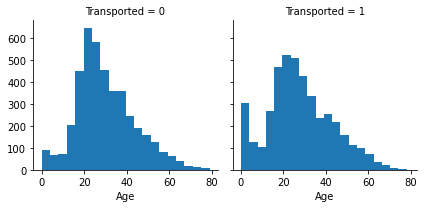

In [26]:
g = sns.FacetGrid(df_train, col=target)
g.map(plt.hist, 'Age', bins=20)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


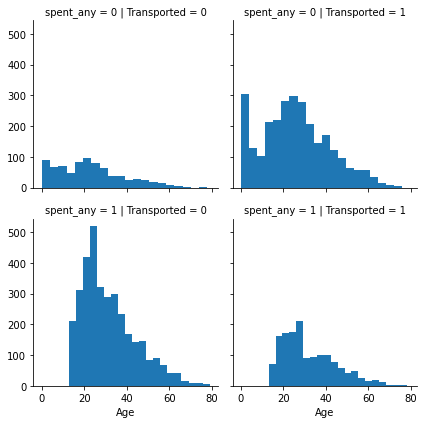

In [27]:
g = sns.FacetGrid(df_train, col=target, row='spent_any')
g.map(plt.hist, 'Age', bins=20)

iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.
iteritems is deprecated and will be removed in a future version. Use .items instead.


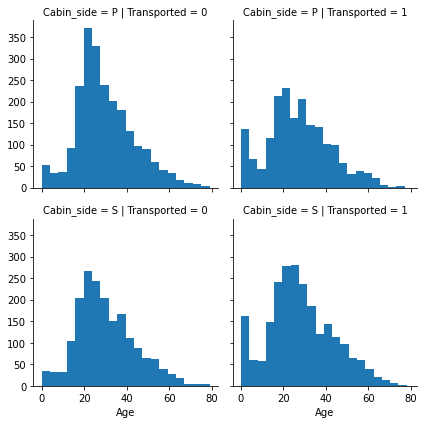

In [28]:
g = sns.FacetGrid(df_train, col=target, row='Cabin_side')
g.map(plt.hist, 'Age', bins=20)

There are a few interesting things seen in the data exploration step:

- Passengers put into suspended animation (CryoSleep) have a much higher chance of being transported to another dimension.
- Passengers in cabins located in the Starboard part of the ship are more likely to be transported as well.
- Age and value spent in the spaceship seem to be great separators of the probability of being transported, with both variables returning a higher chance of transportation the lower their values are.

### Data Manipulation 

Creation of One Hot Encoders for categorical features and filling null values of the dataset.

In [29]:
df_train.dtypes

PassengerId           object
HomePlanet            object
CryoSleep              int32
Cabin                 object
Destination           object
Age                  float64
VIP                    int32
RoomService          float64
FoodCourt            float64
ShoppingMall         float64
Spa                  float64
VRDeck               float64
Name                  object
Transported            int32
Cabin_deck            object
Cabin_num             object
Cabin_side            object
GroupId               object
people_in_group        int32
Last_name             object
family_members       float64
people_in_cabin      float64
total_value_spent    float64
spent_any              int32
Alone                  int32
Private_cabin          int32
dtype: object

In [25]:
# Filling NA and One Hot Encoding for Categorical Features
cols_dummies = ['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side']
df_train[cols_dummies]=df_train[cols_dummies].fillna('NULL')

df_train=pd.get_dummies(df_train, columns=cols_dummies, drop_first='True')

Checking correlated variables.

In [28]:
corr=df_train.select_dtypes(np.number).corr()
corr[target].sort_values() # Features highly correlated with the target

spent_any                   -0.471868
RoomService                 -0.244611
Spa                         -0.221131
VRDeck                      -0.207075
total_value_spent           -0.140420
Cabin_side_P                -0.101397
Cabin_deck_E                -0.097965
Destination_TRAPPIST-1e     -0.094700
Cabin_deck_F                -0.087753
Age                         -0.075026
Private_cabin               -0.037231
Cabin_deck_D                -0.034046
family_members              -0.033312
VIP                         -0.024602
Cabin_deck_T                -0.014568
Cabin_deck_NULL             -0.000340
Destination_PSO J318.5-22    0.000092
Destination_NULL             0.000547
HomePlanet_NULL              0.002712
ShoppingMall                 0.010141
Cabin_deck_G                 0.016269
HomePlanet_Mars              0.019544
Alone                        0.027401
FoodCourt                    0.046566
people_in_cabin              0.078296
people_in_group              0.082644
Cabin_side_S

In [27]:
corr

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NULL,Destination_NULL,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_NULL,Cabin_deck_T,Cabin_side_P,Cabin_side_S
CryoSleep,1.000000,-0.073771,-0.050342,-0.243434,-0.204765,-0.208465,-0.199075,-0.192749,0.451744,0.082696,-0.007762,0.047185,-0.355662,-0.841104,0.009568,-0.051319,0.094665,0.031692,0.002785,-0.026775,0.085744,-0.100486,0.121837,0.031703,-0.067703,-0.110477,-0.217772,0.237359,0.026239,-0.008641,-0.019696,0.011838
Age,-0.073771,1.000000,0.058930,0.068723,0.130421,0.033133,0.123970,0.101007,-0.075026,-0.179102,-0.133882,0.077054,0.175361,0.227470,0.068355,-0.002097,0.219793,0.016273,-0.000363,0.013098,-0.028503,-0.001047,0.104058,0.127957,0.077988,0.028638,-0.018938,-0.212117,0.003390,0.013673,-0.011880,0.010862
VIP,-0.050342,0.058930,1.000000,0.050854,0.089639,-0.001104,0.037446,0.087322,-0.024602,-0.001815,-0.044772,0.058413,0.092819,0.055555,0.005740,-0.020260,0.094805,0.033617,-0.004720,-0.009245,0.006058,-0.029993,0.034473,0.049751,0.043001,-0.019124,-0.035428,-0.062903,0.010245,-0.005282,0.000545,-0.003610
RoomService,-0.243434,0.068723,0.050854,1.000000,-0.015889,0.054480,0.010080,-0.019581,-0.244611,-0.040777,-0.030852,-0.001387,0.294410,0.290126,-0.011393,0.020630,-0.068098,0.248013,-0.005029,-0.003933,-0.063655,0.061780,-0.065617,-0.020310,0.162944,0.044106,0.086898,-0.146530,0.026772,0.007364,0.007583,-0.015591
FoodCourt,-0.204765,0.130421,0.089639,-0.015889,1.000000,-0.014228,0.221891,0.227995,0.046566,0.032632,-0.102193,0.201570,0.786218,0.244413,0.036329,-0.033295,0.369477,-0.126142,-0.018768,-0.010415,-0.066214,-0.074411,0.156435,0.262541,0.020183,-0.039740,-0.133150,-0.151747,0.000343,0.014134,-0.019812,0.019700
ShoppingMall,-0.208465,0.033133,-0.001104,0.054480,-0.014228,1.000000,0.013879,-0.007322,0.010141,-0.038770,-0.038986,-0.012007,0.270929,0.246174,0.019616,0.020777,-0.021282,0.112464,-0.008092,-0.005794,-0.031760,0.033184,-0.010739,0.000934,0.055252,0.031655,0.074909,-0.109245,-0.010420,-0.006222,0.022192,-0.019041
Spa,-0.199075,0.123970,0.037446,0.010080,0.221891,0.013879,1.000000,0.153821,-0.221131,0.019223,-0.067941,0.139243,0.642615,0.236032,0.040532,-0.024183,0.269178,-0.089063,-0.010778,0.007079,-0.053976,-0.034859,0.115679,0.165828,0.034564,-0.011814,-0.088352,-0.125876,0.025807,0.036205,-0.005801,-0.001964
VRDeck,-0.192749,0.101007,0.087322,-0.019581,0.227995,-0.007322,0.153821,1.000000,-0.207075,0.009401,-0.074972,0.127231,0.217949,0.217276,0.029496,-0.018154,0.284801,-0.113128,-0.002701,-0.010777,-0.045816,-0.047128,0.123204,0.208311,-0.003495,-0.018676,-0.095165,-0.128630,-0.007280,0.012239,0.009073,-0.006890
Transported,0.451744,-0.075026,-0.024602,-0.244611,0.046566,0.010141,-0.221131,-0.207075,1.000000,0.082644,-0.033312,0.078296,-0.140420,-0.471868,0.027401,-0.037231,0.176916,0.019544,0.002712,0.000547,0.000092,-0.094700,0.144733,0.108193,-0.034046,-0.097965,-0.087753,0.016269,-0.000340,-0.014568,-0.101397,0.101455
people_in_group,0.082696,-0.179102,-0.001815,-0.040777,0.032632,-0.038770,0.019223,0.009401,0.082644,1.000000,0.343033,0.296143,0.010398,-0.186039,-0.131882,-0.095692,0.132389,-0.021261,-0.002467,-0.004263,-0.057293,-0.014721,0.079807,0.104512,-0.005688,-0.064911,-0.124731,0.039220,0.019721,-0.015563,-0.017522,0.011615


In [37]:
df_train.to_csv('data/intermediate/train_dataset.csv',index=False)

### Modeling Pipeline

We first split the train dataset into train and validation data for testing purposes.
We then fit several models in search of the best accuracy score.

In [29]:
train_cols = list(df_train.select_dtypes(np.number).drop(target,axis=1).columns)

In [33]:
X_train, X_valid, y_train, y_valid = train_test_split(df_train[train_cols].fillna(-1), df_train[target], test_size=0.3, random_state=42)

In [34]:
X_train.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NULL,Destination_NULL,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_NULL,Cabin_deck_T,Cabin_side_P,Cabin_side_S
count,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000,6085.000000
mean,0.367132,28.220707,0.047987,223.974856,461.452424,168.766804,309.929170,302.539688,2.040756,5.298603,7.732293,1164.206081,0.581101,0.039277,0.032210,0.246179,0.199178,0.023007,0.020049,0.093016,0.678882,0.090222,0.086606,0.054067,0.099096,0.325555,0.292194,0.023336,0.000822,0.487592,0.489071
std,0.482063,14.984731,0.213756,684.066677,1602.879048,617.006986,1118.936163,1172.742104,1.601276,3.034007,5.308480,2331.435439,0.493419,0.194269,0.176573,0.430820,0.399415,0.149939,0.140180,0.290478,0.466944,0.286523,0.281281,0.226169,0.298816,0.468620,0.454808,0.150981,0.028656,0.499887,0.499922
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,6.000000,469.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,37.000000,0.000000,42.000000,82.000000,23.000000,54.000000,50.000000,3.000000,7.000000,12.000000,1209.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,27723.000000,23492.000000,18572.000000,24133.000000,8.000000,18.000000,28.000000,27928.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [35]:
X_valid.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,people_in_group,family_members,people_in_cabin,total_value_spent,spent_any,Alone,Private_cabin,HomePlanet_Europa,HomePlanet_Mars,HomePlanet_NULL,Destination_NULL,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,Cabin_deck_B,Cabin_deck_C,Cabin_deck_D,Cabin_deck_E,Cabin_deck_F,Cabin_deck_G,Cabin_deck_NULL,Cabin_deck_T,Cabin_side_P,Cabin_side_S
count,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.000000,2608.0,2608.000000,2608.000000
mean,0.391104,28.197469,0.042178,210.687500,417.989264,171.371933,292.058666,288.208589,2.023390,5.237347,8.059049,1092.203604,0.558282,0.040644,0.027607,0.242715,0.209739,0.023390,0.023006,0.088190,0.684049,0.088190,0.084356,0.057132,0.104678,0.311733,0.299463,0.021856,0.0,0.475077,0.503067
std,0.488091,14.877215,0.201033,602.054872,1579.034886,551.269579,1141.010718,1038.626407,1.585025,2.975548,5.370325,2319.582418,0.496687,0.197502,0.163876,0.428806,0.407201,0.151166,0.149952,0.283626,0.464983,0.283626,0.277974,0.232139,0.306197,0.463290,0.458111,0.146241,0.0,0.499474,0.500086
min,0.000000,-1.000000,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,7.000000,298.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000
75%,1.000000,37.000000,0.000000,34.250000,34.250000,20.000000,52.000000,23.000000,3.000000,7.000000,12.000000,1163.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.0,1.000000,1.000000
max,1.000000,79.000000,1.000000,8586.000000,29813.000000,12253.000000,22408.000000,11643.000000,8.000000,18.000000,28.000000,35970.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


Logistic regression
 Train Set Accuracy: 0.79
Logistic regression
 Validation Set Accuracy: 0.78


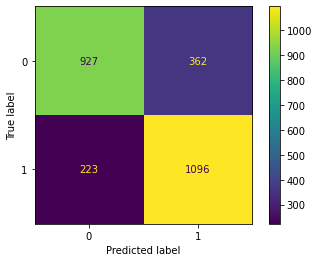

In [36]:
# Logistic Regression
m_logreg = LogisticRegression(random_state=42)
m_logreg = m_logreg.fit(X_train, y_train)

pred_train_logreg = m_logreg.predict(X_train)
pred_logreg = m_logreg.predict(X_valid)

cm = confusion_matrix(y_valid, pred_logreg, labels=m_logreg.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=m_logreg.classes_)
disp.plot()
print("Logistic regression\n Train Set Accuracy:", round(accuracy_score(y_train, pred_train_logreg), 2) )
print("Logistic regression\n Validation Set Accuracy:", round(accuracy_score(y_valid, pred_logreg), 2) )

Random Forest
 Train Set Accuracy: 1.0
Random Forest
 Validation Set Accuracy: 0.79


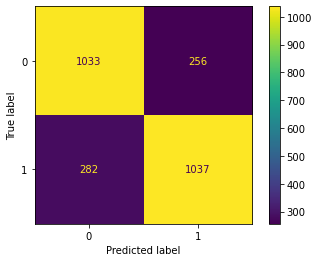

In [37]:
# Random Forest
m_rf = RandomForestClassifier(random_state=42)
m_rf = m_rf.fit(X_train, y_train)

pred_train_rf = m_rf.predict(X_train)
pred_rf = m_rf.predict(X_valid)

cm = confusion_matrix(y_valid, pred_rf, labels=m_rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=m_rf.classes_)
disp.plot()
print("Random Forest\n Train Set Accuracy:", round(accuracy_score(y_train, pred_train_rf), 2) )
print("Random Forest\n Validation Set Accuracy:", round(accuracy_score(y_valid, pred_rf), 2) )

In [38]:
mod_xgb = xgb.XGBClassifier(random_state=42)

# The list of hyper-parameters we want to optimize. For each one we define the
# bounds, the corresponding scikit-learn parameter name, as well as how to
# sample values from that dimension (`'log-uniform'` for the learning rate)
space  = [Integer(1, 15, name='max_depth'),
          Real(0.025, 0.30, name='learning_rate'),
          Integer(1, 7, name='min_child_weight'),
          Real(0, 0.40, name='learning_rate'),
          Real(0.3, 0.7, name='colsample_bytree')
          ]

# this decorator allows your objective function to receive a the parameters as
# keyword arguments. This is particularly convenient when you want to set
# scikit-learn estimator parameters
@use_named_args(space)
def objective(**params):
    mod_xgb.set_params(**params)

    return -np.mean(cross_val_score(mod_xgb, X_train, y_train, cv=5, n_jobs=-1,
                                    scoring="accuracy"))

In [39]:
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=-0.8061'

In [40]:
list_pars_xgb=['max_depth','learning_rate','min_child_weight', 'learning_rate','colsample_bytree']
best_pars_xgb=dict(zip(list_pars_xgb, res_gp.x))

Xgboost with hypertuning
Train Accuracy: 0.95
Xgboost with hypertuning
Valid Accuracy: 0.79


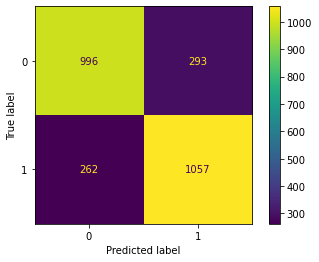

In [41]:
xgb_opt=xgb.XGBClassifier(random_state=42)
xgb_opt.fit(X_train, y_train)

pred_xgb_train = xgb_opt.predict(X_train)
pred_xgb_tuned = xgb_opt.predict(X_valid)

cm = confusion_matrix(y_valid, pred_xgb_tuned, labels=xgb_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=xgb_opt.classes_)
disp.plot()
print("Xgboost with hypertuning\nTrain Accuracy:", round(accuracy_score(y_train, pred_xgb_train), 2) )
print("Xgboost with hypertuning\nValid Accuracy:", round(accuracy_score(y_valid, pred_xgb_tuned), 2) )

Fitting 10 folds for each of 1000 candidates, totalling 10000 fits
[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
LightGBM with hypertuning
Train Accuracy: 0.84
LightGBM with hypertuning
Valid Accuracy: 0.8


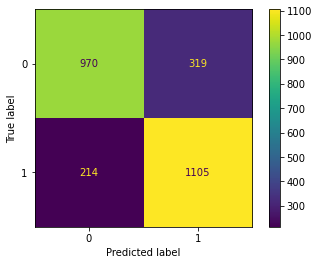

In [42]:
m_lgb = lgb.LGBMClassifier()

random_grid = {'learning_rate': [0.025, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
               'max_depth': [3, 4, 5, 6, 8, 10, 12, 15, 20],
               #'num_leaves': [3, 6, 9, 12, 20, 40],
               'min_child_weight': [1, 3, 5, 7],
               'boosting':['rf', 'dart', 'gbdt'],
               'bagging_fraction':[0, 0.25, 0.5, 0.75, 0.90],
               'bagging_freq':[0, 5, 10, 15],
               'n_iterations':[5, 10, 20, 30, 60],
               #'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
               'colsample_bytree': [0.3, 0.4, 0.5, 0.7]}

lgb_random = RandomizedSearchCV(estimator = m_lgb, 
                                scoring='accuracy', 
                                param_distributions = random_grid, n_iter = 1000, cv = 10, verbose=2, random_state=42, n_jobs = -1)
lgb_random.fit(X_train, y_train)

pred_lgb_train = lgb_random.predict(X_train)
pred_lgb_tuned = lgb_random.predict(X_valid)

cm = confusion_matrix(y_valid, pred_lgb_tuned, labels=lgb_random.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb_random.classes_)
disp.plot()
print("LightGBM with hypertuning\nTrain Accuracy:", round(accuracy_score(y_train, pred_lgb_train), 2) )
print("LightGBM with hypertuning\nValid Accuracy:", round(accuracy_score(y_valid, pred_lgb_tuned), 2) )

In [44]:
lgb_random.best_estimator_

LGBMClassifier(bagging_fraction=0.5, bagging_freq=15, boosting='gbdt',
               colsample_bytree=0.7, learning_rate=0.05, max_depth=8,
               min_child_weight=3, n_iterations=30)

[LightGBM] [Warning] Unknown parameter: n_iterations
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] bagging_freq is set=15, subsample_freq=0 will be ignored. Current value: bagging_freq=15
LightGBM with hypertuning
Train Accuracy: 0.84
LightGBM with hypertuning
Valid Accuracy: 0.8


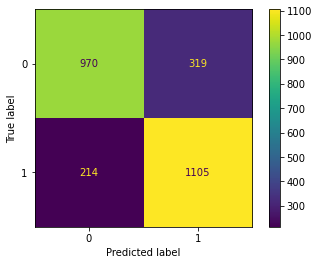

In [45]:
lgb_final=lgb_random.best_estimator_

lgb_final.fit(X_train, y_train)

pred_lgb_train = lgb_final.predict(X_train)
pred_lgb_tuned = lgb_final.predict(X_valid)

cm = confusion_matrix(y_valid, pred_lgb_tuned, labels=lgb_final.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=lgb_final.classes_)
disp.plot()
print("LightGBM with hypertuning\nTrain Accuracy:", round(accuracy_score(y_train, pred_lgb_train), 2) )
print("LightGBM with hypertuning\nValid Accuracy:", round(accuracy_score(y_valid, pred_lgb_tuned), 2) )

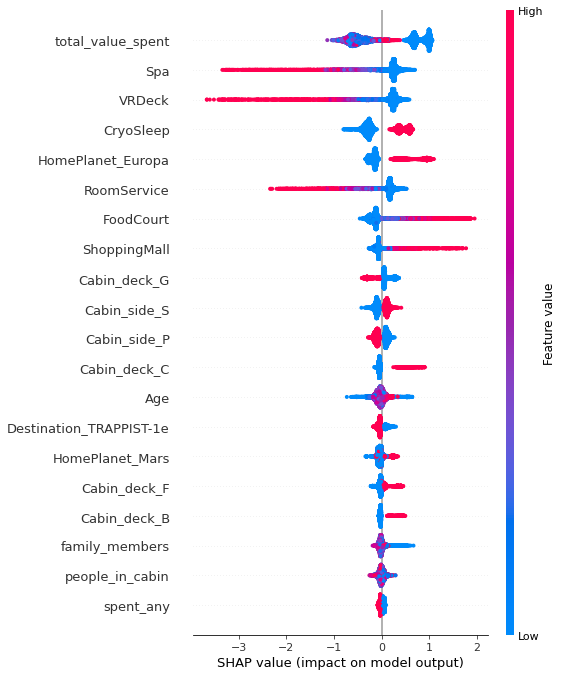

In [46]:
explainer = shap.Explainer(lgb_final)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values[1], X_train)

As the model with the best accuracy on the validation dataset was the LightGBM model (80% accuracy), we followed through with it to predict the results in the test data.

### Test prediction

In [47]:
df_test['CryoSleep']=df_test['CryoSleep'].astype(bool).astype(int)
df_test['VIP']=df_test['VIP'].astype(bool).astype(int)

df_test['Cabin_deck']=df_test['Cabin'].str.split('/', expand=True)[0]
df_test['Cabin_num']=df_test['Cabin'].str.split('/', expand=True)[1]
df_test['Cabin_side']=df_test['Cabin'].str.split('/', expand=True)[2]

df_test['GroupId']=df_test['PassengerId'].str.split('_', expand=True)[0]
passenger_ids=df_test['PassengerId'].str.split('_', expand=True)
passenger_ids=passenger_ids.groupby(0)[1].max().astype(int).reset_index().rename(columns={0:'GroupId', 1:'people_in_group'})

df_test=pd.merge(df_test, passenger_ids, how = 'left', on = ['GroupId'])

df_test['Last_name']=df_test['Name'].str.split(' ', expand=True)[1]
families=df_test['Name'].str.split(' ', expand=True)
families=families.groupby(1)[0].count().reset_index().rename(columns={0:'family_members', 1:'Last_name'})

df_test=pd.merge(df_test, families, how = 'left', on = ['Last_name'])

cabin_vol=df_test.groupby(['Cabin_num'])['PassengerId'].count().reset_index().rename(columns={'PassengerId':'people_in_cabin'})
df_test=pd.merge(df_test, cabin_vol, how = 'left', on = ['Cabin_num'])

df_test['total_value_spent']=df_test[['RoomService',	'FoodCourt',	'ShoppingMall',	'Spa']].sum(axis=1)
df_test['spent_any']=np.where(df_test['total_value_spent']>0,1,0)

df_test['Alone']=np.where((df_test['people_in_group']==1) & (df_test['family_members']==1),1,0)
df_test['Private_cabin']=np.where(df_test['people_in_cabin']==1,1,0)

In [48]:
cols_dummies = ['HomePlanet', 'Destination', 'Cabin_deck', 'Cabin_side']
df_test[cols_dummies]=df_test[cols_dummies].fillna('NULL')
df_test=pd.get_dummies(df_test, columns=cols_dummies, drop_first='True')

In [49]:
df_test.to_csv('data/intermediate/test_dataset.csv',index=False)

In [50]:
df_test['Transported']=lgb_final.predict(df_test[train_cols])

In [51]:
print('Train targets:', y_train.mean())
print('Valid targets:', y_valid.mean())
print('Test targets:', df_test[target].mean())

Train targets: 0.5027115858668858
Valid targets: 0.5057515337423313
Test targets: 0.5440729483282675


In [52]:
df_test['Transported']=df_test['Transported'].astype(bool)

In [53]:
# Saving results to upload on Kaggle
df_test[['PassengerId', 'Transported']].to_csv('data/results/predictions.csv',index=False)